# Xception - Stanford Dogs Dataset Classification

[Xception Paper](https://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf)

The [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. It was originally collected for fine-grain image categorization, a challenging problem as certain dog breeds have near identical features or differ in colour and age.

## Outline
1. Data Import
2. Data Augmentation & Visualization 
3. Xception CNN Import 
4. Model Training
5. Accuracy & Loss Visualization
6. Model Testing
7. Predict Images

In [1]:
!pip install tf_explain

     |████████████████████████████████| 43 kB 2.0 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 1 Data Import

### 1.1 Libraries

In [2]:
# BASIC LIBRARIES
import os # interaction with os

# ARRAYS, MATRICES, IMAGES, VIDEOS, PLOTTING, ML LIBRARIES
import pandas as pd # analyze, clean, explore, manipulate data
import xml.etree.ElementTree as ET # API for parsing and creating XML data
#import gdown # Google Drive file downloader
import time # time-related functions
import math # C-like mathematical functions
import cv2 # image and video processing functions (OpenCV)
import numpy as np # arrays and matrices (linear algebra)
from PIL import Image # support for opening, manipulating, saving different image file formats
from imgaug import augmenters as iaa # image augmentation
import matplotlib.pyplot as plt # MATLAB-like plotting
%matplotlib inline
import matplotlib.image as image # load, rescale, display image
from sklearn.model_selection import train_test_split # split arrays or matrices into random train and test subsets
from sklearn.metrics import classification_report #
import tensorflow as tf # ML library focused on training and inference of deep neural networks
from tensorflow import keras # high-level TensorFlow API
from keras.utils import np_utils # utilities for array and list manipulation
from keras.utils import Sequence # object for fitting to a sequence of data, such as a dataset
from tensorflow.keras import layers # basic building blocks of neural networks
from tensorflow.keras.preprocessing.image import ImageDataGenerator # generate batches of tensor image data with real-time data augmentation
from tf_explain.core.activations import ExtractActivations # extract activation functions

# MODEL ARCHITECTURE SPECIFIC LIBRARIES
from keras.applications.xception import Xception, decode_predictions, preprocess_input # instantiates Xception architecture, decodes prediction of ImageNet model, preprocesses tensor or array encoding batch of images
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping # callback is an object that can perform actions at various stages of training
# ModelCheckpoint saves Keras model or model weights at some frequency
# ReduceLROnPlateau reduces learning rate when a metric has stopped improving
# EarlyStopping stops training when a monitored metric has stopped improving
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D # specific layers (see later)
from keras.layers import Dropout, Flatten, Dense # specific layers (see later)
from keras.models import Sequential # groups layers into a model

print("LIBRARIES LOADED")

LIBRARIES LOADED


### 1.2 Data

In [3]:
image_path = '../input/stanford-dogs-dataset/images/Images'
num_categories = 120
image_size = 299
batch_size = 16

In [4]:
breed_list = sorted(os.listdir(image_path)) # sorted list of all files and directories in path (in this case 120 directories, each containing images of a specific dog breed)
num_classes = len(breed_list) # number of dog breeds
print("{} breeds".format(num_classes))

120 breeds


In [5]:
# define time counter function to test algorithm performance

_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

### 1.3 Generate Data Folder with Cropped Pictures

[Dogs Inception - PyTorch Implementation](https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation)

In [6]:
os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

Created 120 folders to store cropped images of the different breeds.


In [7]:
%%time
for breed in os.listdir('data'):
    for file in os.listdir('../input/stanford-dogs-dataset/annotations/Annotation/{}'.format(breed)):
        img = Image.open('../input/stanford-dogs-dataset/images/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('../input/stanford-dogs-dataset/annotations/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((image_size, image_size))
        img.save('data/' + breed + '/' + file + '.jpg')

CPU times: user 2min 46s, sys: 4.98 s, total: 2min 51s
Wall time: 6min 6s


### 1.4 Print Cropped Images

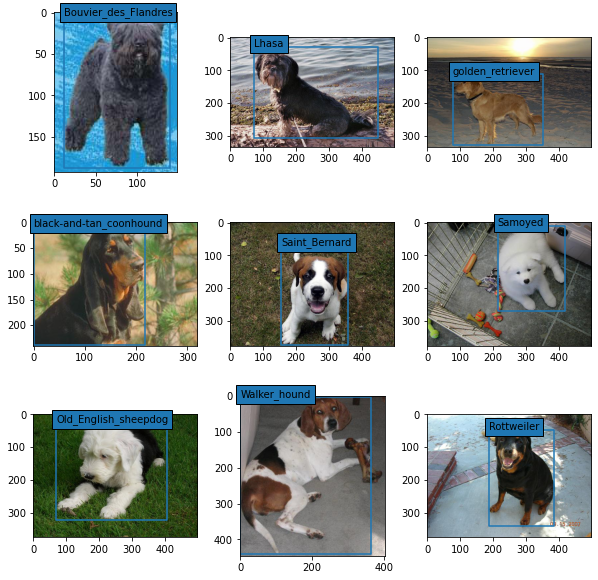

In [8]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(331 + i) # show 9 random images
    breed = np.random.choice(breed_list) # random breed
    dog = np.random.choice(os.listdir('../input/stanford-dogs-dataset/annotations/Annotation/' + breed)) # random image 
    img = Image.open('../input/stanford-dogs-dataset/images/Images/' + breed + '/' + dog + '.jpg') 
    tree = ET.parse('../input/stanford-dogs-dataset/annotations/Annotation/' + breed + '/' + dog) # init parser for file given
    root = tree.getroot()
    objects = root.findall('object') # find all dogs
    plt.imshow(img) # display photo
    for o in objects:
        bndbox = o.find('bndbox') # read border coordinates
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin]) # show border
        plt.text(xmin, ymin, o.find('name').text, bbox={'ec': None}) # print breed

## 2 Data Augmentation & Visualization

### 2.1 Define Paths (X) and Labels (y)

In [9]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [10]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

### 2.2 Define Image Generator with Custom Augmentation

In [11]:
class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = cv2.imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.Sometimes(0.5,
                    
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-40, 40),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

### 2.3 Split X and y into Train, Validation, Test

In [12]:
x_train, x_test, y_train, y_test = train_test_split(paths, targets, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

train_ds = ImageGenerator(x_train, y_train, batch_size=32, shape=(image_size, image_size,3), augment=True)
val_ds = ImageGenerator(x_test, y_test, batch_size=32, shape=(image_size, image_size,3), augment=False)
test_ds = ImageGenerator(x_test, y_test, batch_size=32, shape=(image_size, image_size,3), augment=False)

## 3 Xception CNN Import

### 3.1 Xception CNN Import

In [13]:
base_model = tf.keras.applications.xception.Xception(weights='imagenet',include_top=False, pooling='avg')#Summary of Xception Model
base_model.trainable = False

83689472/83683744 [==============================] - 4s 0us/step


### 3.2 Fully Connected Layer Implementation

In [14]:
flat_dim = 5 * 5 * 2048

my_model = Sequential(base_model)
my_model.add(Dense(1032, activation='relu', input_dim=flat_dim))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dense(256, activation='relu'))
my_model.add(Dense(120, activation='softmax'))

### 3.3 Define Callbacks and Compile Model

[1e-05, 6.505114555849587e-06, 1.3998974074878144e-05, 2.1158257692363077e-05, 2.6349806140466085e-05, 2.9032781503571898e-05, 2.9396559030789573e-05, 2.7979491786027585e-05, 2.540182222438155e-05, 2.2217993076484613e-05, 1.885603456913674e-05, 1.5609303737669377e-05, 1.265427690063973e-05, 1.0077640616334645e-05, 7.903437440340427e-06, 6.116030942221757e-06, 4.677609611772819e-06, 3.5404805065519026e-06, 2.655051675737932e-06, 1.9745568653868732e-06, 1.457488127964179e-06, 1.068520029068309e-06, 7.785125464502897e-07, 5.640054703120814e-07, 4.0647805168961314e-07]


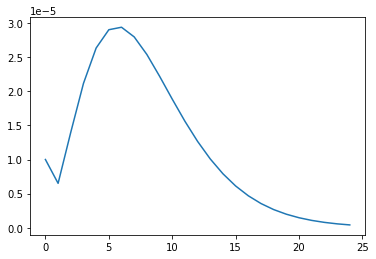

In [15]:
total_epoch = 8
learning_rate_init = 0.00001

def lr_scheduler(epoch):
    epoch += 1
   
    if epoch == 1:
        return learning_rate_init
    
    elif epoch >= 2 and epoch <= 40:
        return (0.2*epoch**3)*math.exp(-0.45*epoch)*learning_rate_init
    
    else:
        return lr_scheduler(40-1)
    

stage = [i for i in range(0,25)]
learning_rate = [lr_scheduler(x) for x in stage]
plt.plot(stage, learning_rate)
print(learning_rate)

In [16]:
scheduler = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience = 6, mode='max', min_delta=1, verbose=1)

In [17]:
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 4 Model Training

In [18]:
process_time_starts()
hist = my_model.fit_generator(generator=train_ds, steps_per_epoch=400, validation_data=val_ds,  validation_steps=90, epochs=8, callbacks=[scheduler])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/8
400/400 [==============================] - 116s 291ms/step - loss: 4.6504 - accuracy: 0.0991 - val_loss: 4.4140 - val_accuracy: 0.2698 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 6.505114555849587e-06.
Epoch 2/8
400/400 [==============================] - 116s 291ms/step - loss: 4.2252 - accuracy: 0.3171 - val_loss: 3.9143 - val_accuracy: 0.4365 - lr: 6.5051e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 1.3998974074878144e-05.
Epoch 3/8
400/400 [==============================] - 116s 291ms/step - loss: 3.2850 - accuracy: 0.4742 - val_loss: 2.3913 - val_accuracy: 0.6094 - lr: 1.3999e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 2.1158257692363077e-05.
Epoch 4/8
400/400 [==============================] - 115s 288ms/step - loss: 1.8824 - accuracy: 0.6412 - val_loss: 1.1583 - val_accuracy: 0.7806 - lr: 2.1158e-05

Epoch 00005: LearningRate

In [19]:
time_elapsed()

The process took: 0hour:15min:41sec


## 5. Accuracy & Loss Visualization

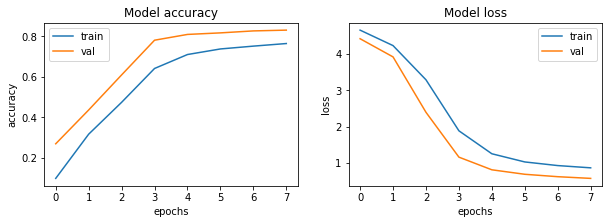

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 5.1 Save model and parameters

In [21]:
my_model.save('my_model.h5', overwrite=True) 
my_model.save_weights('dog_breed_xcept_weights.h5', overwrite=True)
print("Saved model to disk")

Saved model to disk


## 6 Model Testing

In [22]:
test_loss, test_accuracy = my_model.evaluate_generator(generator=test_ds,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

Test results 
 Loss: 0.5761249661445618 
 Accuracy 0.8293750286102295


## 7 Predict Images

In [23]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((299, 299))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = image.imread(filename)
    img = preprocess_input(img)
    probs = my_model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

83.13% 	 malinois
4.68% 	 German_shepherd
2.35% 	 kelpie
1.88% 	 dingo
1.55% 	 Doberman


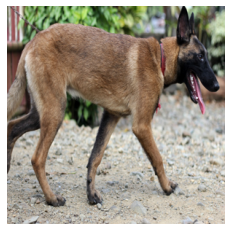

In [24]:
download_and_predict("https://cdn.pixabay.com/photo/2018/08/12/02/52/belgian-mallinois-3599991_1280.jpg",
                     "test_1.jpg")



46.15% 	 Brittany_spaniel
17.76% 	 Welsh_springer_spaniel
12.48% 	 Irish_setter
7.18% 	 golden_retriever
3.02% 	 English_setter


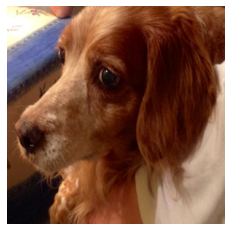

In [25]:
download_and_predict("http://giandonet.altervista.org/Marco/ala.JPG",
                     "test_2.jpg")


43.35% 	 toy_terrier
13.35% 	 boxer
9.07% 	 Boston_bull
4.06% 	 pug
2.98% 	 Mexican_hairless


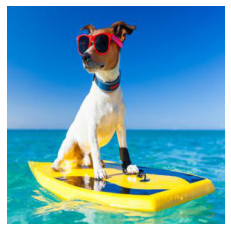

In [26]:
download_and_predict("http://giandonet.altervista.org/Marco/surfingdog.jpg",
                     "test_3.jpg")